In [1]:
import warnings
warnings.filterwarnings("ignore")

from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np

Consider the reaction: A -> B -> C modeled by the following ODEs:
        
$$\frac{dA}{dt}=-k_1 A$$
$$\frac{dB}{dt}=k_1 A-k_2 B$$

with initial conditions: $A(0)=1, B(0)=0$. Fit the ODEs to the following experimental data set and find $k_1$ and $k_2$:

|Time |  0.1 |  0.2 |  0.3 |  0.4 |  0.5 |  0.6 |  0.7 |  0.8 |  0.9 |  1.0 |
|-----|------|------|------|------|------|------|------|------|------|------|
|A    | 0.606| 0.368| 0.223| 0.135| 0.082| 0.050| 0.030| 0.018| 0.011| 0.007|
|B    | 0.373| 0.564| 0.647| 0.669| 0.656| 0.624| 0.583| 0.539| 0.494| 0.451|

Reference: Pyomo Workshop Dec 2023

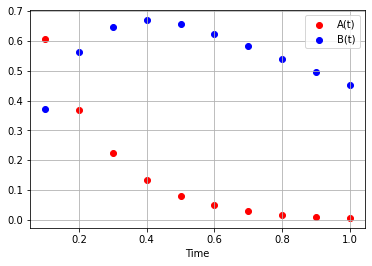

In [2]:
A_data = {0.1:0.606, 0.2:0.368, 0.3:0.223, 0.4:0.135, 0.5:0.082, 0.6:0.050, 0.7:0.030, 0.8:0.018, 0.9:0.011, 1.0:0.007}
B_data = {0.1:0.373, 0.2:0.564, 0.3:0.647, 0.4:0.669, 0.5:0.656, 0.6:0.624, 0.7:0.583, 0.8:0.539, 0.9:0.494, 1.0:0.451}

plt.scatter(A_data.keys(), A_data.values(), c='r', label='A(t)')
plt.scatter(B_data.keys(), B_data.values(), c='b', label='B(t)')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

Please recompile / update your pynumero_ASL library.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1090
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      142

Total number of variables............................:      246
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables w

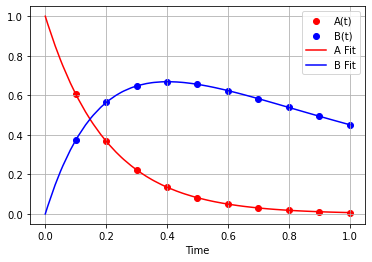

In [3]:
m = ConcreteModel()
m.t = ContinuousSet(initialize=A_data.keys(), bounds=(0, 1))

m.A = Var(m.t)              # Many values over m.t
m.B = Var(m.t)              # Many values over m.t
m.k1 = Var(bounds=(0, 10))  # Scalar value only
m.k2 = Var(bounds=(0, 10))  # Scalar value only

m.dAdt = DerivativeVar(m.A, wrt=m.t)
m.dBdt = DerivativeVar(m.B, wrt=m.t)

def _init_con(m):
    yield m.A[0] == 1
    yield m.B[0] == 0
m.init_con = ConstraintList(rule=_init_con)

def _dAdt(m, i):
    return m.dAdt[i] == -m.k1*m.A[i]
m.dAdtcon = Constraint(m.t, rule=_dAdt)

def _dBdt(m, i):
    return m.dBdt[i] == m.k1*m.A[i] - m.k2*m.B[i]
m.dBdtcon = Constraint(m.t, rule=_dBdt)

def _obj(m):
    return sum((m.A[i] - A_data[i])**2 for i in A_data.keys()) +\
           sum((m.B[i] - B_data[i])**2 for i in B_data.keys())
m.obj = Objective(rule=_obj)

discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=20, ncp=3, scheme='LAGRANGE-RADAU')

solver = SolverFactory('cyipopt')
res = solver.solve(m, tee=True)

t = list(m.t)
A_fit = [value(m.A[i]) for i in m.t]
B_fit = [value(m.B[i]) for i in m.t]

print(f'k1 = {value(m.k1)}')
print(f'k2 = {value(m.k2)}')

plt.scatter(A_data.keys(), A_data.values(), c='r', label='A(t)')
plt.scatter(B_data.keys(), B_data.values(), c='b', label='B(t)')
plt.plot(t, A_fit, c='r', label='A Fit')
plt.plot(t, B_fit, c='b', label='B Fit')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

# Try a data set with some noise

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1090
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      142

Total number of variables............................:      246
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:      244
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

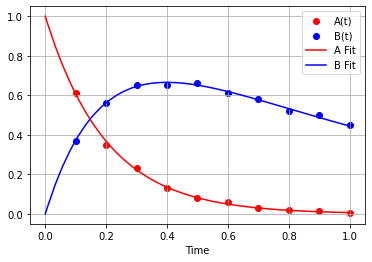

In [4]:
A_data = {0.1:0.61, 0.2:0.35, 0.3:0.23, 0.4:0.13, 0.5:0.08, 0.6:0.06, 0.7:0.028, 0.8:0.022, 0.9:0.014, 1.0:0.003}
B_data = {0.1:0.37, 0.2:0.56, 0.3:0.65, 0.4:0.65, 0.5:0.66, 0.6:0.61, 0.7:0.58, 0.8:0.52, 0.9:0.5, 1.0:0.45}

m = ConcreteModel()
m.t = ContinuousSet(initialize=A_data.keys(), bounds=(0, 1))

m.A = Var(m.t)              # Many values over m.t
m.B = Var(m.t)              # Many values over m.t
m.k1 = Var(bounds=(0, 10))  # Scalar value only
m.k2 = Var(bounds=(0, 10))  # Scalar value only

m.dAdt = DerivativeVar(m.A, wrt=m.t)
m.dBdt = DerivativeVar(m.B, wrt=m.t)

def _init_con(m):
    yield m.A[0] == 1
    yield m.B[0] == 0
m.init_con = ConstraintList(rule=_init_con)

def _dAdt(m, i):
    return m.dAdt[i] == -m.k1*m.A[i]
m.dAdtcon = Constraint(m.t, rule=_dAdt)

def _dBdt(m, i):
    return m.dBdt[i] == m.k1*m.A[i] - m.k2*m.B[i]
m.dBdtcon = Constraint(m.t, rule=_dBdt)

def _obj(m):
    return sum((m.A[i] - A_data[i])**2 for i in A_data.keys()) +\
           sum((m.B[i] - B_data[i])**2 for i in B_data.keys())
m.obj = Objective(rule=_obj)

discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=20, ncp=3, scheme='LAGRANGE-RADAU')

solver = SolverFactory('cyipopt')
res = solver.solve(m, tee=True)

t = list(m.t)
A_fit = [value(m.A[i]) for i in m.t]
B_fit = [value(m.B[i]) for i in m.t]

print(f'k1 = {value(m.k1)}')
print(f'k2 = {value(m.k2)}')

plt.scatter(A_data.keys(), A_data.values(), c='r', label='A(t)')
plt.scatter(B_data.keys(), B_data.values(), c='b', label='B(t)')
plt.plot(t, A_fit, c='r', label='A Fit')
plt.plot(t, B_fit, c='b', label='B Fit')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()